In [1]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import skewnorm 
import pandas as pd
from tqdm import tqdm

def pt_d_sample_test(data1, data2, c, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    if max_depth < 0:

       max_depth = 8

    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])   #with two columns
    X = data[:, 0]  # assign the first column to X
    discrete_values = np.unique(binary)    #[0,1]

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    logbf = p_H0 - p_H1

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]   #counts the number of data in each interval


    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)    #alpha

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  #natural log of beta function
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions


    return logl + np.sum(likelihoods)

def scale(data):
    return (data - np.mean(data)) / np.std(data)      #standardize

In [ ]:
fig = plt.figure()
ax = plt.axes()
a = -8
b = -3
x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 500)
ax.plot(x, skewnorm.pdf(x, a), 'r-', lw = 5, alpha = 0.6)
ax.plot(x, skewnorm.pdf(x, b), 'green', lw = 5, alpha = 0.6)
plt.show
pt_d_sample_test(skewnorm.pdf(x, a), skewnorm.pdf(x, b), c = 0.1, log_BF = True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Generate the skew normal distributions
a = -8
b = -5
print(skewnorm.ppf(0.01, a))
x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 500)

fig = plt.figure()
ax = plt.axes()
ax.plot(x, skewnorm.pdf(x, a), 'r-', lw=5, alpha=0.6, label='a = -8')
ax.plot(x, skewnorm.pdf(x, b), 'green', lw=5, alpha=0.6, label='b = -3')
ax.legend()
plt.show()



# Run pt_d_sample_test with different values of c and store the results
c_values = [0.01, 0.05, 0.1, 1, 3, 6, 10]
results = []

for c in c_values:
    result = pt_d_sample_test(skewnorm.pdf(x, a), skewnorm.pdf(x, b),max_depth= 10, c=c, log_BF=True)
    results.append(result)

# Plot the results
plt.figure()
plt.plot(c_values, results, 'o-', lw=2)
plt.xlabel('c')
plt.ylabel('Value returned by pt_d_sample_test')
plt.title('Results of pt_d_sample_test with different c values')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the parameters for the normal distributions
mean1, std1 = 0, 1  # N(0,1)
mean2, std2 = 5, 1  # N(1,1)

# Generate x values
x = np.linspace(-4, 20, 1000)

# Generate the PDFs for the two normal distributions
pdf1 = norm.pdf(x, mean1, std1)
pdf2 = norm.pdf(x, mean2, std2)

# Plot the PDFs
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1, 'b-', lw=2, alpha=0.6, label='N(0,1)')
plt.plot(x, pdf2, 'g-', lw=2, alpha=0.6, label='N(1,1)')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.grid(True)


plt.show()


# Null Case

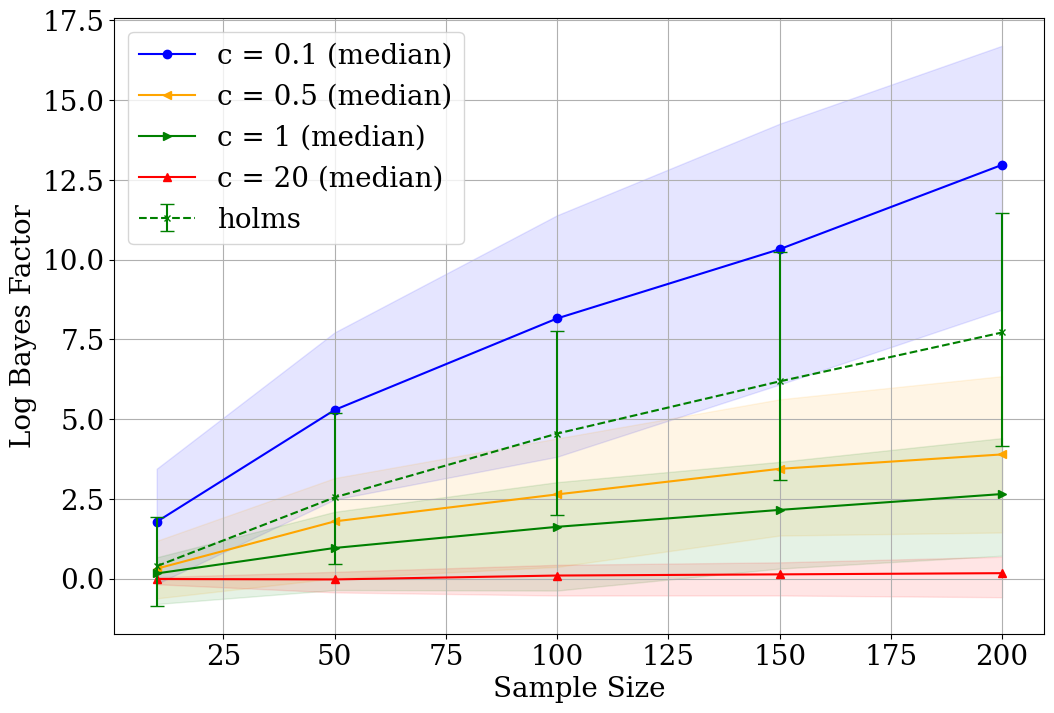

In [10]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def calculate_bayes_factors(sample_sizes, rep, c):
    size = len(sample_sizes)
    bfmatrix = np.empty((size, rep))

    for i in range(size):
        for j in range(rep):
            data1 = np.random.normal(size=sample_sizes[i])
            data2 = np.random.normal(size=sample_sizes[i])
            bfmatrix[i, j] = pt_d_sample_test(data1, data2, c=c, log_BF=True)

    row_percentiles = np.percentile(bfmatrix, [16, 50, 84], axis=1)
    return bfmatrix, row_percentiles

sample_sizes = [10, 50, 100, 150, 200]
rep = 500

bfmatrix_c_0_1, bf_percentiles_c_0_1 = calculate_bayes_factors(sample_sizes, rep, c=0.1)
bfmatrix_c_0_12, bf_percentiles_c_0_12 = calculate_bayes_factors(sample_sizes, rep, c=0.5)
bfmatrix_c_0_18, bf_percentiles_c_0_18 = calculate_bayes_factors(sample_sizes, rep, c=1)
bfmatrix_c_0_5, bf_percentiles_c_0_5 = calculate_bayes_factors(sample_sizes, rep, c=20)


additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [0.3896103896103895, 2.545454545454545, 4.545454545454545, 6.181818181818181, 7.7142857142857135]
additional_upper_bounds = [1.93, 5.195, 7.747, 10.229, 11.448]
additional_lower_bounds = [-0.85, 0.45, 2, 3.1, 4.16]

df_additional = pd.DataFrame({
    'SampleSize': additional_sample_sizes,
    'MeanRowValue': additional_row_means,
    'UpperBound': additional_upper_bounds,
    'LowerBound': additional_lower_bounds
})

size = 20 
mpl.rcParams.update({
    "font.size": size,             
    "font.family": "serif",         
    "axes.labelsize": size,          
    "xtick.labelsize": size,          
    "ytick.labelsize": size,         
    "legend.fontsize": size,        
    "figure.titlesize": size          
})

plt.figure(figsize=(12, 8))


plt.plot(sample_sizes, bf_percentiles_c_0_1[1], label='c = 0.1 (median)', marker='o', color='blue')
plt.fill_between(sample_sizes, bf_percentiles_c_0_1[0], bf_percentiles_c_0_1[2], color='blue', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_12[1], label='c = 0.5 (median)', marker='<', color='orange')
plt.fill_between(sample_sizes, bf_percentiles_c_0_12[0], bf_percentiles_c_0_12[2], color='orange', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_18[1], label='c = 1 (median)', marker='>', color='green')
plt.fill_between(sample_sizes, bf_percentiles_c_0_18[0], bf_percentiles_c_0_18[2], color='green', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_5[1], label='c = 20 (median)', marker='^', color='red')
plt.fill_between(sample_sizes, bf_percentiles_c_0_5[0], bf_percentiles_c_0_5[2], color='red', alpha=0.1)

# Holmes
plt.errorbar(df_additional['SampleSize'], df_additional['MeanRowValue'],
             yerr=[df_additional['MeanRowValue'] - df_additional['LowerBound'],
                   df_additional['UpperBound'] - df_additional['MeanRowValue']],
             fmt='x', color='green', linestyle='--', markersize=5, label='holms', capsize=5)

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')

plt.legend()
plt.grid(True)

import os
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
filename = os.path.join(desktop, "nullcase.pdf")
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

# Mean Shift Case

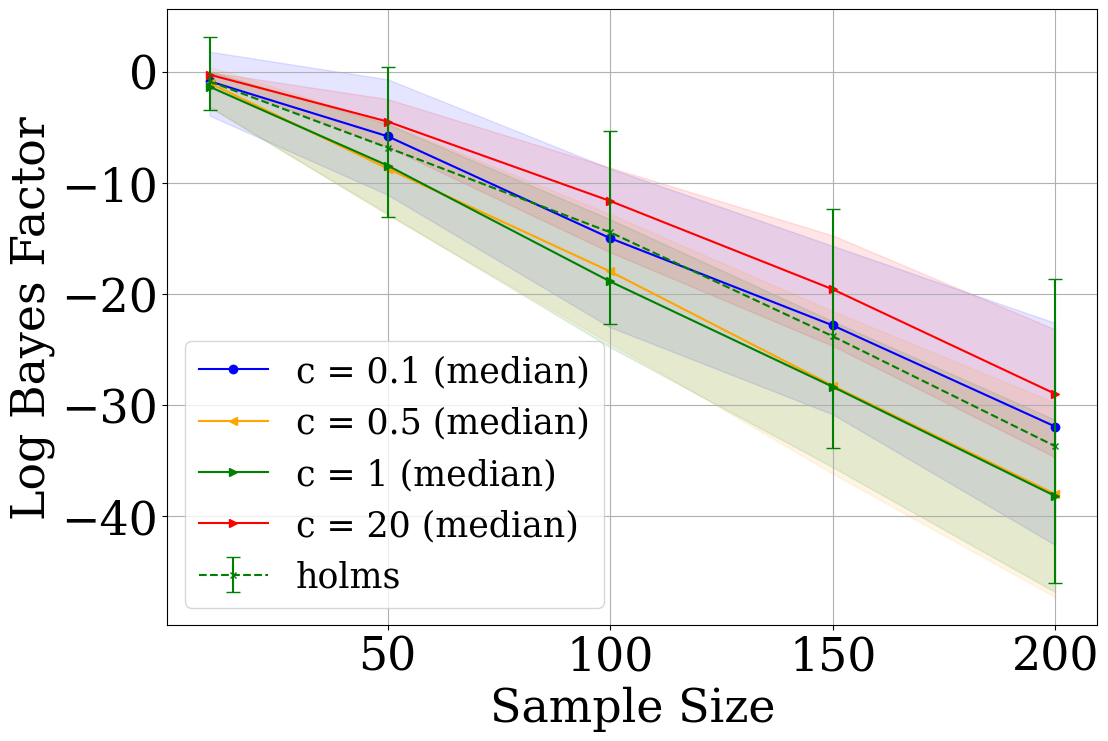

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_bayes_factors(sample_sizes, rep, c):
    size = len(sample_sizes)
    bfmatrix = np.empty((size, rep))

    for i in range(size):
        for j in range(rep):
            data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
            data2 = np.random.normal(loc=1, scale=1,size=sample_sizes[i])
            bfmatrix[i, j] = pt_d_sample_test(data1, data2, c=c, log_BF=True)

    row_percentiles = np.percentile(bfmatrix, [16, 50, 84], axis=1)
    return bfmatrix, row_percentiles

sample_sizes = [10, 50, 100, 150, 200]
rep = 500

bfmatrix_c_0_1, bf_percentiles_c_0_1 = calculate_bayes_factors(sample_sizes, rep, c=0.1)
bfmatrix_c_0_12, bf_percentiles_c_0_5 = calculate_bayes_factors(sample_sizes, rep, c=0.5)
bfmatrix_c_0_18, bf_percentiles_c_1 = calculate_bayes_factors(sample_sizes, rep, c=1)
bfmatrix_c_0_5, bf_percentiles_c_5 = calculate_bayes_factors(sample_sizes, rep, c=20)

additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [-0.8899663720966604, -6.846797528740124, -14.455306170329235, -23.803081254398997, -33.69515914600766]
additional_upper_bounds = [3.09, 0.45, -5.34, -12.38, -18.63]
additional_lower_bounds = [-3.499, -13.068, -22.727, -33.8636, -46.022]

df_additional = pd.DataFrame({
    'SampleSize': additional_sample_sizes,
    'MeanRowValue': additional_row_means,
    'UpperBound': additional_upper_bounds,
    'LowerBound': additional_lower_bounds
})


size = 33
mpl.rcParams.update({
    "font.size": size,             
    "font.family": "serif",         
    "axes.labelsize": size,          
    "xtick.labelsize": size,          
    "ytick.labelsize": size,         
    "legend.fontsize": 25,        
    "figure.titlesize": size          
})


plt.figure(figsize=(12, 8))


plt.plot(sample_sizes, bf_percentiles_c_0_1[1], label='c = 0.1 (median)', marker='o', color='blue')
plt.fill_between(sample_sizes, bf_percentiles_c_0_1[0], bf_percentiles_c_0_1[2], color='blue', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_5[1], label='c = 0.5 (median)', marker='<', color='orange')
plt.fill_between(sample_sizes, bf_percentiles_c_0_5[0], bf_percentiles_c_0_5[2], color='orange', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_1[1], label='c = 1 (median)', marker='>', color='green')
plt.fill_between(sample_sizes, bf_percentiles_c_1[0], bf_percentiles_c_1[2], color='green', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_5[1], label='c = 20 (median)', marker='>', color='red')
plt.fill_between(sample_sizes, bf_percentiles_c_5[0], bf_percentiles_c_5[2], color='red', alpha=0.1)

# Plot additional data with error bars
plt.errorbar(df_additional['SampleSize'], df_additional['MeanRowValue'],
             yerr=[df_additional['MeanRowValue'] - df_additional['LowerBound'],
                   df_additional['UpperBound'] - df_additional['MeanRowValue']],
             fmt='x', color='green', linestyle='--', markersize=5, label='holms', capsize=5)

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.legend()
plt.grid(True)

import os
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
filename = os.path.join(desktop, "meanshiftcase.pdf")
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()


# Variance Shift Case

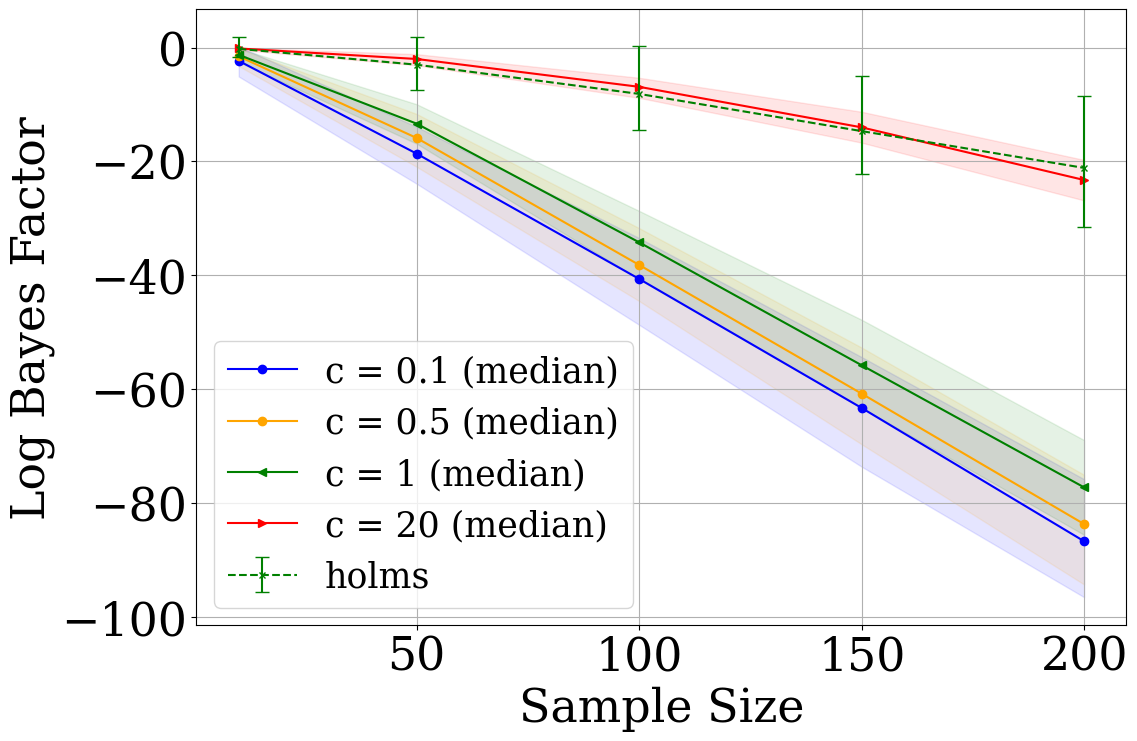

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_bayes_factors(sample_sizes, rep, c):
    size = len(sample_sizes)
    bfmatrix = np.empty((size, rep))

    for i in range(size):
        for j in range(rep):
            data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
            data2 = np.random.normal(loc=0, scale=4,size=sample_sizes[i])
            bfmatrix[i, j] = pt_d_sample_test(data1, data2, c=c, log_BF=True)

    row_percentiles = np.percentile(bfmatrix, [16, 50, 84], axis=1)
    return bfmatrix, row_percentiles

sample_sizes = [10, 50, 100, 150, 200]
rep = 500

bfmatrix_c_0_1, bf_percentiles_c_5 = calculate_bayes_factors(sample_sizes, rep, c=0.1)
bfmatrix_c_0_05, bf_percentiles_c_05 = calculate_bayes_factors(sample_sizes, rep, c=0.5)
bfmatrix_c_0_12, bf_percentiles_c_10 = calculate_bayes_factors(sample_sizes, rep, c=1)
bfmatrix_c_0_18, bf_percentiles_c_25 = calculate_bayes_factors(sample_sizes, rep, c=20)

additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [-0.21315789473684355, -2.9991228070175477, -8.132456140350886, -14.665350877192992, -21.130701754385974]
additional_upper_bounds = [1.81, 1.83, 0.22, -5, -8.56]
additional_lower_bounds = [-1.72, -7.42, -14.544, -22.12, -31.51]

df_additional = pd.DataFrame({
    'SampleSize': additional_sample_sizes,
    'MeanRowValue': additional_row_means,
    'UpperBound': additional_upper_bounds,
    'LowerBound': additional_lower_bounds
})


size = 33 
mpl.rcParams.update({
    "font.size": size,             
    "font.family": "serif",         
    "axes.labelsize": size,          
    "xtick.labelsize": size,          
    "ytick.labelsize": size,         
    "legend.fontsize": 25,        
    "figure.titlesize": size          
})


plt.figure(figsize=(12, 8))


plt.plot(sample_sizes, bf_percentiles_c_5[1], label='c = 0.1 (median)', marker='o', color='blue')
plt.fill_between(sample_sizes, bf_percentiles_c_5[0], bf_percentiles_c_5[2], color='blue', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_05[1], label='c = 0.5 (median)', marker='o', color='orange')
plt.fill_between(sample_sizes, bf_percentiles_c_05[0], bf_percentiles_c_05[2], color='orange', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_10[1], label='c = 1 (median)', marker='<', color='green')
plt.fill_between(sample_sizes, bf_percentiles_c_10[0], bf_percentiles_c_10[2], color='green', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_25[1], label='c = 20 (median)', marker='>', color='red')
plt.fill_between(sample_sizes, bf_percentiles_c_25[0], bf_percentiles_c_25[2], color='red', alpha=0.1)

# Plot additional data with error bars
plt.errorbar(df_additional['SampleSize'], df_additional['MeanRowValue'],
             yerr=[df_additional['MeanRowValue'] - df_additional['LowerBound'],
                   df_additional['UpperBound'] - df_additional['MeanRowValue']],
             fmt='x', color='green', linestyle='--', markersize=5, label='holms', capsize=5)

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')

plt.legend()
plt.grid(True)

import os
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
filename = os.path.join(desktop, "varshiftcase.pdf")
plt.savefig(filename, dpi=300, bbox_inches='tight')


plt.show()


# tail